In [ ]:
# Download glove.6b.100d.txt
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

# Installation of additional libraries
!pip install -q annoy
!pip install -q datasets
!pip install -q transformers

--2022-09-09 05:09:01--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-09-09 05:09:01--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-09-09 05:09:02--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
import pandas as pd
import numpy as np

import spacy
import re
import os

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import Dataset, DataLoader


from annoy import AnnoyIndex
from datasets import load_metric, Dataset, DatasetDict, load_dataset
from transformers import AutoTokenizer, TrainingArguments, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification,Trainer, TrainingArguments
import datasets
from datasets import load_metric
# import wandb

from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# Data Exploration

## Class distribution


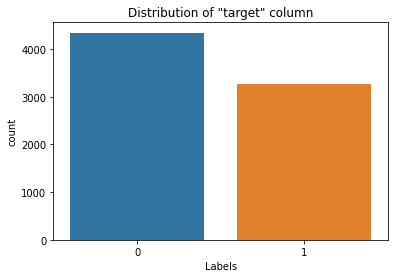

In [ ]:
sns.countplot(df_train['target'])
plt.title('Distribution of "target" column')
plt.xlabel('Labels');

## Clean text

Clean text from URL and left only letters

In [ ]:
def clean_text(tweets):
    patterns =[r"http\S+",
               r"[^a-zA-Z]",
               r"@eileenmfl",
               r"wrongdejavu",
               r"bestnaijamade"]
    for pattern in patterns:
        tweets = re.sub(pattern, " ", tweets)

    tweets = re.sub("goooooooaaaaaal","goal", tweets)
    tweets = re.sub("looooool","lol", tweets)
    tweets = re.sub("cooool","cool", tweets)
    tweets = re.sub("traumatise","traumatize", tweets)
    tweets = re.sub("prebreak","pre break", tweets)
    tweets = re.sub("worldnew","world new", tweets)
    tweets = re.sub("nowplaye","now play", tweets)
    tweets = re.sub("hwo","who", tweets)
    tweets = re.sub("animalrescue","animal rescue", tweets)
    tweets = re.sub("prophetmuhammad","prophet muhammad", tweets)
    tweets = re.sub("viralspell","viral spell", tweets)
    tweets = re.sub("usagov","usa gov", tweets)

    return tweets.lower()

In [ ]:
df_train['text'] = df_train['text'].apply(clean_text)
df_test['text'] = df_test['text'].apply(clean_text)

Remove stop word

In [ ]:
# Disable the useless pipelines led to decrease the run time of function "lemmatization" more than 20 times

nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "ner", "tok2vec", "scores", "attribute_ruler"])

def remove_stopwords(tweets):
    tweets = ' '.join([word for word in tweets.split()
                       if word not in nlp.Defaults.stop_words and len(word) > 2])
    return tweets

In [ ]:
df_train['text'] = df_train['text'].apply(remove_stopwords)
df_test['text'] = df_test['text'].apply(remove_stopwords)

Make lemmatization

In [ ]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner", "scores"])

def lemmatization(tweets):
    doc = nlp(tweets)
    tweets = [token.lemma_ for token in doc]
    return tweets

In [ ]:
df_train['text'] = df_train['text'].apply(lemmatization)
df_test['text'] = df_test['text'].apply(lemmatization)

## Most popular words in disaster and not disaster tweets

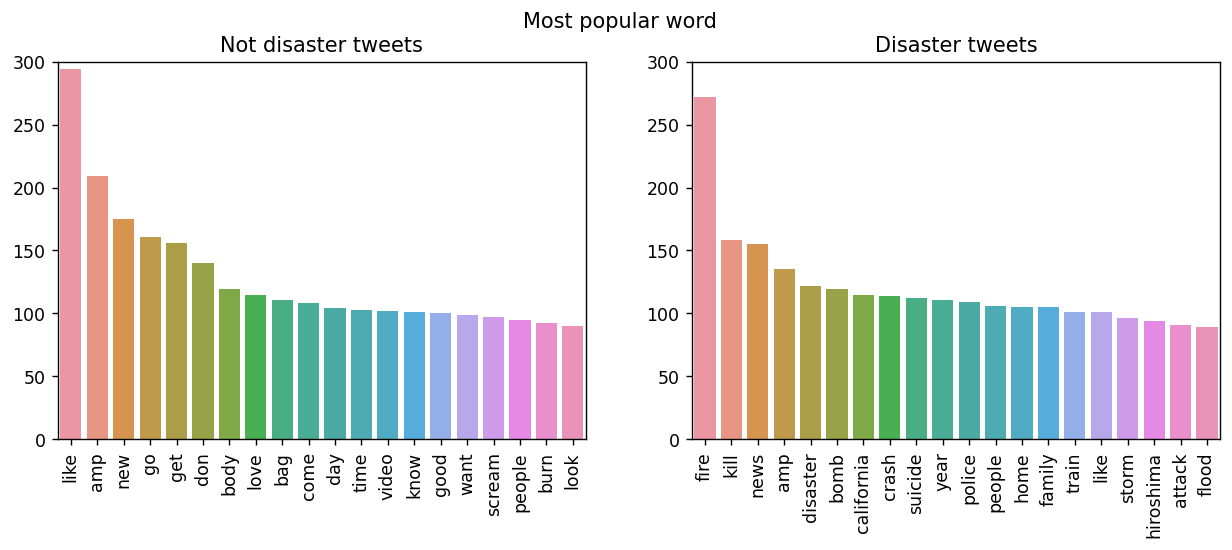

In [ ]:
# Count words in both classes

disaster_full_text = []
not_disaster_full_text = []
df_train[df_train['target']==0]['text'].apply(lambda x: not_disaster_full_text.append(x))
df_train[df_train['target']==1]['text'].apply(lambda x: disaster_full_text.append(x))

not_dis_word_qty = Counter([word for sentence in not_disaster_full_text for word in sentence])
dis_word_qty = Counter([word for sentence in disaster_full_text for word in sentence])

# Plot barplots

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=125)
fig.suptitle('Most popular word')

sns.barplot(ax=axes[0],
            x=[count[0] for count in not_dis_word_qty.most_common(20)],
            y=[count[1] for count in not_dis_word_qty.most_common(20)])
axes[0].set_title('Not disaster tweets')
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_ylim(0, 300)


sns.barplot(ax=axes[1],
            x=[count[0] for count in dis_word_qty.most_common(20)],
            y=[count[1] for count in dis_word_qty.most_common(20)])
axes[1].set_title('Disaster tweets')
axes[1].tick_params(axis='x', rotation=90)
axes[1].set_ylim(0, 300);

# Training and plotting functions

In [ ]:
def acc_loss_plotting(train_losses, val_losses, train_acc, val_acc):
    plt.figure(figsize=(8, 4), dpi=100)
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='train loss')
    plt.plot(val_losses, label='val loss')
    plt.title('Losses')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='train accuracy')
    plt.plot(val_acc, label='val accuracy')
    plt.title('Accuracy')
    plt.show()

In [ ]:
def training(device, model, epochs, optimizer, loss_function, train_loader, valid_loader, early_stopping=False, predict=False):
    patient = 2
    trigger_times=0

    train_losses = []
    val_losses = []

    train_acc = []
    val_acc = []

    for epoch in range(epochs):

        trn_corr = 0

        for b, (data, label) in enumerate(train_loader):
            data = data.to(device)
            label = label.to(device)

            y_pred = model(data)

            loss = criterion(y_pred, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            prediction = torch.round(y_pred)
            trn_corr += (prediction == label).sum()

        train_losses.append(loss.to('cpu').detach().item())

        if not predict:
            # Calculate loss and accuracy for validation data
            val_corr = 0
            with torch.no_grad():
                for data, label in valid_loader:
                    data = data.to(device)  
                    label = label.to(device)

                    y_pred = model(data)
                    
                    val_loss = criterion(y_pred, label)
            
                    prediction = torch.round(y_pred)
                    val_corr += (prediction == label).sum()

            val_losses.append(val_loss.to('cpu').detach().item())


            train_acc.append(trn_corr.to('cpu').detach().item() / len(train_dataset)*100)
            val_acc.append(val_corr.to('cpu').detach().item() / len(val_dataset)*100)

            if epoch % 5 == 0:
                print(f"Epoch: {epoch:{3}} \
                train_loss: {loss.item():.4f} \
                val_loss: {val_loss.item():.4f} \
                train accuracy: {train_acc[-1]:.2f} % \
                val accuracy: {val_acc[-1]:.2f} %")

            # Early stopping
            if epoch > (patient+1):
                if (val_losses[-1] > val_losses[-2]) and early_stopping:
                    trigger_times += 1

                    if trigger_times >= patient:
                        print(f'Early stopping! Epoch = {epoch}')
                        
                        acc_loss_plotting(train_losses, val_losses, train_acc, val_acc)

                        return model
                    
                else:
                    trigger_times = 0
    if not predict:
        acc_loss_plotting(train_losses, val_losses, train_acc, val_acc)
    return model

# Two nn.Linear model (Score: 0.79589)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# Tokenization and vocabulary creation
tokenizer = get_tokenizer('basic_english')
def yield_tokens(data):
    for text in data:
        for word in text:
            yield tokenizer(word)

vocab = build_vocab_from_iterator(yield_tokens(df_train['text']), specials=['<unk>'], min_freq=2)
vocab.set_default_index(vocab['<unk>'])

In [ ]:
print(f"Vocabulary length = {len(vocab)}")

Vocabulary length = 5168


In [ ]:
# Translating text into tokens
print(vocab(['earthquake', 'fire', 'nuclear']))

[182, 2, 52]


In [ ]:
class TweetDataset(Dataset):
    """
    Args:
        tweets: tweets samples.
        labels: target.
        vocab_size (int): Size of vocabulary.
    """
    
    def __init__(self, tweets, labels, vocab_size):
        self.tweets = tweets.tolist()
        self.labels = torch.tensor(labels.values, dtype=torch.float).unsqueeze(1)
        self.vocab_size = vocab_size

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        data = torch.zeros(self.vocab_size)
        # print(data)
        data[vocab(self.tweets[idx])] = 1.0

        return data, self.labels[idx]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_train['text'],
                                                    df_train['target'],
                                                    train_size=0.7,
                                                  random_state=42)

train_dataset = TweetDataset(X_train, 
                         y_train,
                         vocab_size=len(vocab))

val_dataset = TweetDataset(X_val,
                        y_val,
                        vocab_size=len(vocab))

full_dataset = TweetDataset(df_train['text'],
                        df_train['target'],
                        vocab_size=len(vocab))

In [ ]:
train_dl = DataLoader(dataset = train_dataset,
                      batch_size=3000,
                      shuffle=True)

val_dl = DataLoader(dataset=val_dataset,
                     batch_size=3000,
                     shuffle=False)

full_dl = DataLoader(dataset=full_dataset,
                     batch_size=3000,
                     shuffle=True)

In [ ]:
class ANNmodel(nn.Module):

    def __init__(self, vocab_size, out_size):

        super().__init__()

        self.fc1 = nn.Linear(vocab_size, 5000)
        self.fc2 = nn.Linear(5000, out_size)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = self.fc2(X)

        return torch.sigmoid(X)

In [ ]:
model = ANNmodel(len(vocab), out_size=1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch:   0                 train_loss: 0.6902                 val_loss: 0.6877                 train accuracy: 58.75 %                 val accuracy: 65.94 %
Epoch:   5                 train_loss: 0.6572                 val_loss: 0.6644                 train accuracy: 76.36 %                 val accuracy: 72.81 %
Epoch:  10                 train_loss: 0.6209                 val_loss: 0.6385                 train accuracy: 81.48 %                 val accuracy: 76.18 %
Epoch:  15                 train_loss: 0.5756                 val_loss: 0.6075                 train accuracy: 84.76 %                 val accuracy: 77.93 %
Epoch:  20                 train_loss: 0.5230                 val_loss: 0.5722                 train accuracy: 86.47 %                 val accuracy: 79.29 %
Epoch:  25                 train_loss: 0.4693                 val_loss: 0.5364                 train accuracy: 87.77 %                 val accuracy: 80.17 %
Epoch:  30                 train_loss: 0.4184             

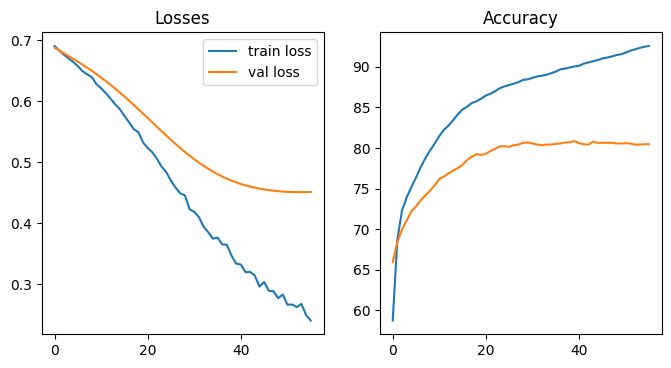

In [ ]:
model = training(device=device,
                 model=model,
                 epochs=100,
                 optimizer=optimizer,
                 loss_function=criterion,
                 train_loader=train_dl,
                 valid_loader=val_dl,
                 early_stopping=True)

In [ ]:
# Train model on full data
model = ANNmodel(len(vocab), out_size=1).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

model = training(device=device, 
                 model=model, 
                 epochs=50, 
                 optimizer=optimizer, 
                 loss_function=criterion, 
                 train_loader=full_dl, 
                 valid_loader=val_dl, 
                 early_stopping=False, 
                 predict=True)
print('Model training complete!')

# Prepare data from test.csv
def tweet_to_tensor(tweet):
    data = np.zeros(len(vocab))
    data[vocab(tweet)] = 1.0
    return torch.Tensor(data)

tensor = df_test['text'].apply(tweet_to_tensor).values

# Prediction
predictions = []
with torch.no_grad():
    for data in tensor:
        data = data.to(device)
        prediction = model(data)
        predictions.append(round(prediction.item()))

df_predict = pd.concat([df_test['id'], pd.DataFrame(predictions, dtype='int', columns=['target'])], axis=1)
df_predict.to_csv('linear_model_submission.csv', index=False)
print("Prediction complete!")

Model training complete!
Prediction complete!


# Embedding+LSTM model (Score: 0.76034)

In [ ]:
max_seq_len = df_train['text'].str.len().max()
max_seq_len

21

In [ ]:
class TweetDataset(Dataset):
    """
    Args:
        tweets: Tweets samples.
        labels: target.
        vocab_size (int): Size of vocabulary.
    """
    
    def __init__(self, tweets, labels, vocab_size, max_seq_len):
        self.tweets = list(map(lambda x: np.pad(x, (0, max_seq_len-len(x))), tweets.apply(lambda x: vocab(x))))
        self.labels = torch.tensor(labels.values, dtype=torch.float).unsqueeze(1)
        self.vocab_size = vocab_size

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, idx):
        data = torch.LongTensor(self.tweets[idx])

        return data, self.labels[idx]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_train['text'],
                                                    df_train['target'],
                                                    train_size=0.7,
                                                  random_state=42)

train_dataset = TweetDataset(X_train,
                         y_train,
                         vocab_size=len(vocab),
                         max_seq_len=max_seq_len)

val_dataset = TweetDataset(X_val,
                        y_val,
                        vocab_size=len(vocab),
                        max_seq_len=max_seq_len)

full_dataset = TweetDataset(df_train['text'],
                           df_train['target'],
                           vocab_size=len(vocab),
                           max_seq_len=max_seq_len)

In [ ]:
train_dl = DataLoader(dataset = train_dataset,
                      batch_size=2000,
                      shuffle=True)

val_dl = DataLoader(dataset=val_dataset,
                     batch_size=2000,
                    shuffle=False)

val_dl = DataLoader(dataset=val_dataset,
                     batch_size=2000)

In [ ]:
class LSTMmodel(nn.Module):

    def __init__(self, vocab_size, emb_dim, out_size):

        super().__init__()

        self.emb = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, 50, num_layers=1)
        self.fc1 = nn.LazyLinear(1)
        self.fc2 = nn.LazyLinear(1)

    def forward(self, X):
        X = self.emb(X).sum(dim=1)
        X, (h_n, c_n) = self.lstm(X)
        X = self.fc1(X)

        return torch.sigmoid(X)

In [ ]:
model = LSTMmodel(vocab_size=len(vocab), emb_dim=20, out_size=1).to('cpu')
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch:   0                 train_loss: 0.6816                 val_loss: 0.6772                 train accuracy: 57.14 %                 val accuracy: 57.75 %
Epoch:   5                 train_loss: 0.6617                 val_loss: 0.6685                 train accuracy: 59.39 %                 val accuracy: 59.59 %
Epoch:  10                 train_loss: 0.6490                 val_loss: 0.6575                 train accuracy: 62.92 %                 val accuracy: 62.17 %
Epoch:  15                 train_loss: 0.6212                 val_loss: 0.6448                 train accuracy: 65.79 %                 val accuracy: 63.66 %
Epoch:  20                 train_loss: 0.5983                 val_loss: 0.6301                 train accuracy: 68.34 %                 val accuracy: 65.11 %
Epoch:  25                 train_loss: 0.5829                 val_loss: 0.6120                 train accuracy: 70.82 %                 val accuracy: 66.37 %
Epoch:  30                 train_loss: 0.5469             

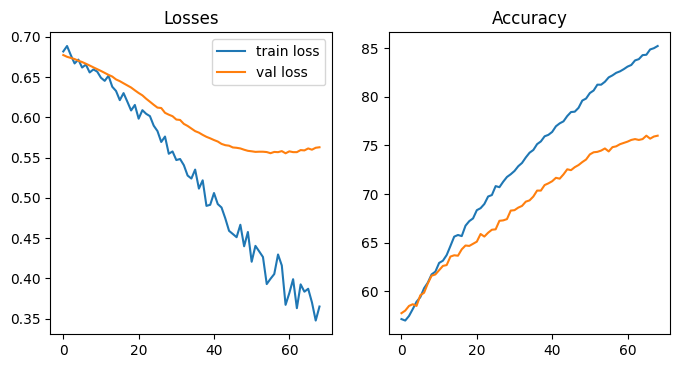

In [ ]:
model = training(device='cpu',
                 model=model,
                 epochs=100,
                 optimizer=optimizer,
                 loss_function=criterion,
                 train_loader=train_dl,
                 valid_loader=val_dl,
                 early_stopping=True)

In [ ]:
# Train model on full data
model = LSTMmodel(vocab_size=len(vocab), emb_dim=20, out_size=1).to('cpu')
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = training(device='cpu',
                 model=model,
                 epochs=70,
                 optimizer=optimizer,
                 loss_function=criterion,
                 train_loader=train_dl,
                 valid_loader=val_dl,
                 early_stopping=False,
                 predict=True)
print('Model training complete!')

# Prepare data from test.csv
def tweet_to_tensor(tweet):
    return torch.LongTensor(list(map(lambda x: np.pad(x, (0, 21-len(x))), tweet.apply(lambda x: vocab(x)))))

tensor = tweet_to_tensor(df_test['text'])

# Prediction
with torch.no_grad():
    y_pred2 = model(tensor)
prediction = np.round(y_pred2)

df_predict = pd.concat([df_test['id'], pd.DataFrame(prediction, dtype='int', columns=['target'])], axis=1)
df_predict.to_csv('LSTM_model_submission.csv', index=False)
print("Prediction complete!")

Model training complete!
Prediction complete!


# Glove embedding model (Score: 0.76800)

In [ ]:
class PreTrainedEmbeddings(object):
    
    def __init__(self, word_to_index, word_vectors):
        """
        Args:
            word_to_index (dict): mapping from word to integers
            word_vectors (list of numpy arrays)
        """
        self.word_to_index = word_to_index
        self.word_vectors = word_vectors
        self.index_to_word = {v: k for k, v in self.word_to_index.items()}

        self.index = AnnoyIndex(len(word_vectors[0]), metric='euclidean')
        print("Building Index!")
        for _, i in self.word_to_index.items():
            self.index.add_item(i, self.word_vectors[i])
        self.index.build(50)
        print("Finished!")
        
    @classmethod
    def from_embeddings_file(cls, embedding_file):
        """Instantiate from pre-trained vector file.
        Args:
            embedding_file (str): file location
        Returns: 
            instance of PretrainedEmbeddings
        """
        word_to_index = {}
        word_vectors = []

        with open(embedding_file) as fp:
            for line in fp.readlines():
                line = line.split(" ")
                word = line[0]
                vec = np.array([float(x) for x in line[1:]])
                
                word_to_index[word] = len(word_to_index)
                word_vectors.append(vec)
                
        return cls(word_to_index, word_vectors)
    
    def get_embedding(self, word):
        """
        Args:
            word (str)
        Returns
            an embedding (numpy.ndarray)
        """
        return self.word_vectors[self.word_to_index[word]]

In [ ]:
embeddings = PreTrainedEmbeddings.from_embeddings_file('glove.6B.100d.txt')

Building Index!
Finished!


In [ ]:
class TweetDataset(Dataset):
    """
    Args:
        tweets: Tweets samples.
        labels: target.
    """
    
    def __init__(self, tweet, labels):
        self.tweet = tweet.tolist()
        self.labels = torch.tensor(labels.values, dtype=torch.float).unsqueeze(1)

    def __len__(self):
        return len(self.tweet)

    def __getitem__(self, idx):
        emb = [embeddings.get_embedding(x) for x in self.tweet[idx] if x in embeddings.word_to_index]
        data_zeros = np.zeros((21,100))
        if len(emb) > 0:
            data_zeros[:len(emb), :] = emb
        data = torch.Tensor(data_zeros)
        return data, self.labels[idx]

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df_train['text'],
                                                    df_train['target'],
                                                    train_size=0.7,
                                                    random_state=42)

train_dataset = TweetDataset(X_train, y_train)

val_dataset = TweetDataset(X_val, y_val)

full_dataset = TweetDataset(df_train['text'], df_train['target'])

In [ ]:
train_dl = DataLoader(dataset = train_dataset,
                      batch_size=3000,
                      shuffle=True)

val_dl = DataLoader(dataset=val_dataset,
                     batch_size=3000,
                    shuffle=False)

full_dl = DataLoader(dataset=full_dataset,
                     batch_size=3000,
                     shuffle=False)

In [ ]:
class LSTMmodel(nn.Module):

    def __init__(self, emb_dim, out_size):

        super().__init__()

        self.lstm = nn.LSTM(emb_dim, 50, num_layers=1, bidirectional=True)
        self.fc1 = nn.LazyLinear(1)
        self.fc2 = nn.LazyLinear(1)

    def forward(self, X):
        X, (h_n, c_n) = self.lstm(X)
        X = self.fc1(X).sum(1)

        return torch.sigmoid(X)

In [ ]:
model = LSTMmodel(emb_dim=100, out_size=1).to('cpu')
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

Epoch:   0                 train_loss: 0.7344                 val_loss: 0.7258                 train accuracy: 56.75 %                 val accuracy: 57.71 %
Epoch:   5                 train_loss: 0.6819                 val_loss: 0.6796                 train accuracy: 57.03 %                 val accuracy: 57.92 %
Epoch:  10                 train_loss: 0.6746                 val_loss: 0.6717                 train accuracy: 61.31 %                 val accuracy: 60.46 %
Epoch:  15                 train_loss: 0.6554                 val_loss: 0.6546                 train accuracy: 63.11 %                 val accuracy: 64.49 %
Epoch:  20                 train_loss: 0.6464                 val_loss: 0.6416                 train accuracy: 63.37 %                 val accuracy: 65.02 %
Epoch:  25                 train_loss: 0.6301                 val_loss: 0.6298                 train accuracy: 66.75 %                 val accuracy: 68.56 %
Epoch:  30                 train_loss: 0.6201             

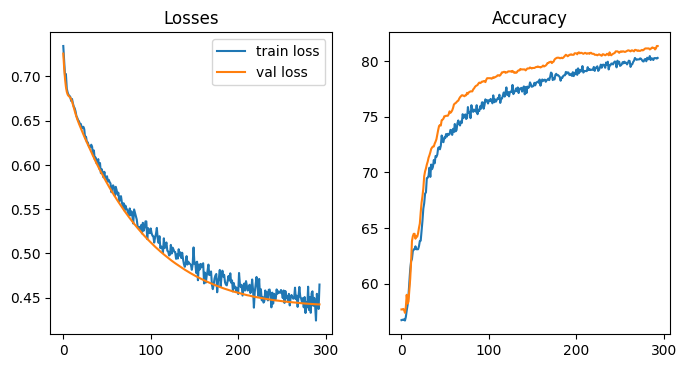

In [ ]:
model = training(device='cpu',
                 model=model,
                 epochs=300,
                 optimizer=optimizer,
                 loss_function=criterion,
                 train_loader=train_dl,
                 valid_loader=val_dl,
                 early_stopping=True)

In [ ]:
# Train model on full data
model = LSTMmodel(emb_dim=100, out_size=1).to('cpu')
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

model = training(device='cpu',
                 model=model,
                 epochs=280,
                 optimizer=optimizer,
                 loss_function=criterion,
                 train_loader=train_dl,
                 valid_loader=val_dl,
                 early_stopping=True,
                 predict=True)
print('Model training complete!')

# Prepare data from test.csv
def tweets_to_tensor(tweet):
    emb = [embeddings.get_embedding(x) for x in tweet if x in embeddings.word_to_index]
    data_zeros = np.zeros((21,100))
    if len(emb) > 0:
        data_zeros[:len(emb), :] = emb
    data = torch.Tensor(data_zeros)
    return data

tensor = df_test['text'].apply(tweets_to_tensor).values

# Prediction
predictions = []
with torch.no_grad():
    for data in tensor:
        data = data.to('cpu')
        prediction = model(data.unsqueeze(0))
        predictions.append(round(prediction.item()))

df_predict = pd.concat([df_test['id'], pd.DataFrame(predictions, dtype='int', columns=['target'])], axis=1)
df_predict.to_csv('GLOVE_LSTM_model_submission.csv', index=False)
print("Prediction complete!")

Model training complete!
Prediction complete!


# Fine-tunning BERT model (Score: 0.81366)

In [ ]:
max_seq_len = df_train['text'].str.len().max()
max_seq_len

21

In [ ]:
# Prepare train dataset
df_train['text'] = df_train['text'].apply(lambda x: " ".join(x))
df_train.drop(['id', 'keyword', 'location'], axis=1, inplace=True)
df_train.rename(columns={"text": "text", "target": "label"}, inplace=True)
dataset = Dataset.from_pandas(df_train, )

# Prepare test dataset
df_test['text'] = df_test['text'].apply(lambda x: " ".join(x))
df_test_id = df_test['id']
df_test.drop(['id', 'keyword', 'location'], axis=1, inplace=True)

dataset_test = Dataset.from_pandas(df_test, )

In [ ]:
# Tweet tokenization
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=max_seq_len)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

In [ ]:
# Download BERT model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

In [ ]:
training_args = TrainingArguments(output_dir="test_trainer")

In [ ]:
metric = load_metric("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
training_args = TrainingArguments(output_dir="test_trainer", 
                                  evaluation_strategy="epoch",
                                  num_train_epochs=1)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets,
    eval_dataset=tokenized_datasets,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

In [ ]:
# Tweet tokenization
tokenized_test_dataset = dataset_test.map(tokenize_function, batched=True)

# Predict
prediction = trainer.predict(tokenized_test_dataset)

# Save submission
df_predict = pd.concat([df_test_id, pd.DataFrame(np.argmax(prediction[0], axis=1), dtype='int', columns=['target'])], axis=1)
df_predict.to_csv('BERT_submission.csv', index=False)
print(f"Prediction complete!")

  0%|          | 0/4 [00:00<?, ?ba/s]

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 3263
  Batch size = 8


# Fine tunning ROBERT model (Score: 0.81612)

In [ ]:
# load model and tokenizer and define length of the text sequence
model = RobertaForSequenceClassification.from_pretrained('roberta-base')
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base', max_length = max_seq_len)

In [ ]:
# define a function that will tokenize the model, and will return the relevant inputs for the model
def tokenization(batched_text):
    return tokenizer(batched_text['text'], padding = True, truncation=True)


train_data = dataset.map(tokenization, batched = True, batch_size = len(dataset)) #
# test_data = test_data.map(tokenization, batched = True, batch_size = len(test_data))

In [ ]:
train_data.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [ ]:
# define accuracy metrics
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
# define the training arguments
training_args = TrainingArguments(
    output_dir = '/content/sample_data/results',
    num_train_epochs=4,
    per_device_train_batch_size = 4,
    gradient_accumulation_steps = 16,    
    per_device_eval_batch_size= 8,
    load_best_model_at_end = True,
    evaluation_strategy = "epoch",
    save_strategy = 'epoch',
    disable_tqdm = False, 
    warmup_steps=500,
    weight_decay=0.01,
    # logging_steps = 8,
    # fp16 = True,
    logging_dir='/content/sample_data/logs',
    dataloader_num_workers = 8,
    # run_name = 'roberta-classification'
)

In [ ]:
# instantiate the trainer class and check for available devices
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=train_data
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# train the model
trainer.train()

In [ ]:
# Tweet tokenization
tokenized_test_dataset = dataset_test.map(tokenization, batched = True, batch_size = len(dataset)) # 

prediction = trainer.predict(tokenized_test_dataset)

# Save submission
df_predict = pd.concat([df_test_id, pd.DataFrame(np.argmax(prediction[0], axis=1), dtype='int', columns=['target'])], axis=1)
df_predict.to_csv('ROBERT_submission.csv', index=False)
print('Prediction complete!')

# Score: 0.78486 - 1 epoch
# Score: 0.57033 - 3 epoch

# Score: 0.80692 - 3 epoch
# Score: 0.81244 - 6 epoch

# Score: 0.81612 - 5 epoch

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: text. If text are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 3263
  Batch size = 8


Prediction complete!
